In [15]:
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import openpyxl as px
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def fetch_sp500_tickers():
    # Wikipedia page with S&P 500 constituents table
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

    # Read the first table on the page (constituents)
    tables = pd.read_html(url)
    sp500_table = tables[0]
    
    # Extract the 'Symbol' column, which holds tickers
    tickers = sp500_table['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]
    tickers.append('SPY')
    
    return tickers


In [18]:
spy = yf.download('SPY', period = '5y') 
assets = yf.download('tickers', period = '5y') 
assets = assets.dropna()

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['TICKERS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [19]:
#Quarterly returns
def compute_momentum(prices):
    ret1 = prices.pct_change(1).shift(1)
    ret3 = prices.pct_change(3).shift(1)
    ret6 = prices.pct_change(6).shift(1)
    ret12 = prices.pct_change(12).shift(1)
    return (ret1 + ret3 + ret6 + ret12) / 4

momentum = compute_momentum(monthly_prices)


In [20]:
z_scores = momentum.apply(lambda row: (row - row.mean()) / row.std(), axis=1)


In [21]:
long_returns = []
short_returns = []
dates = []

for date in z_scores.index[12:]:  # Start after momentum history builds up
    z_row = z_scores.loc[date]
    next_month_ret = monthly_returns.shift(-1).loc[date]

    top_15 = z_row.nlargest(15).dropna().index
    bottom_15 = z_row.nsmallest(15).dropna().index

    if not top_15.empty and not bottom_15.empty:
        long_ret = next_month_ret[top_15].mean()
        short_ret = next_month_ret[bottom_15].mean()
    else:
        long_ret, short_ret = 0, 0

    long_returns.append(long_ret)
    short_returns.append(short_ret)
    dates.append(date)

In [22]:
# --- Step 6: Build performance DataFrame ---
results = pd.DataFrame({
    'Long': long_returns,
    'Short': short_returns,
    'Long-Short': np.array(long_returns) - np.array(short_returns)
}, index=pd.to_datetime(dates))

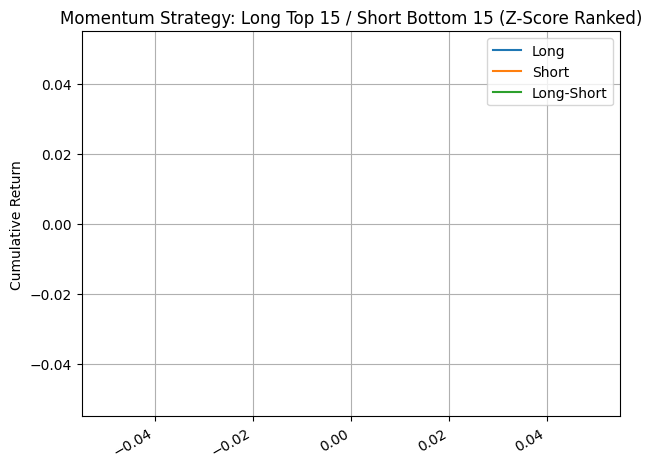

In [23]:
# --- Step 7: Plot cumulative performance ---
(1 + results).cumprod().plot(title="Momentum Strategy: Long Top 15 / Short Bottom 15 (Z-Score Ranked)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()